# Workflow for training a pixel-based semantic segmentation model 

Load in Packages

In [ ]:
import numpy as np
import pandas as pd    
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,BatchNormalization,ReLU,MaxPooling2D,Conv2DTranspose,concatenate,GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import sklearn.metrics
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pickle
from tensorflow.keras import models
from tensorflow.keras import initializers

Load in the test and training arrays

In [ ]:
testarray = np.load('testarray.npy')
trainarray = np.load('trainarray.npy')

Preprocessing steps

In [ ]:
## randomise training data
permuted_index = np.random.permutation(len(trainarray))
trainarray = trainarray[permuted_index,...]

## split out data and labeles
# test data
testData = testarray[...,0:4]
testData.shape
# test label
testLabel = testarray[...,4].max(axis=(1,2))
testLabel.shape
# training data
trainData = trainarray[...,0:4]
trainData.shape
# training label
trainLabel = trainarray[...,4].max(axis=(1,2))
trainLabel.shape

## set model variables to standard names
x_train = trainData
y_train = trainLabel
x_test = testData
y_test = testLabel

## Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

#print resulting shapes to check
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (2560, 256, 256, 4)
2560 train samples
512 test samples


Split out 10% for validation dataset


In [ ]:
#added split out of validation data
x_training = x_train[0:int(len(x_train)*0.9),...]
y_training = y_train[0:int(len(y_train)*0.9),...]
x_validation = x_train[int(len(y_train)*0.9):int(len(x_train)),...]
y_validation = y_train[int(len(y_train)*0.9):int(len(x_train)),...]

Set data augmentation

In [ ]:
datagen = ImageDataGenerator(
   # rotation_range=20, fill_mode='constant',cval=0,
    #brightness_range= (0.8,1),
    horizontal_flip=True, 
    #vertical_flip=True,
    #shear_range = 0.2,
    #validation_split=0.1
    )

Create model infrastructure - UNet

In [ ]:
input_shape = (256,256,4)

kernel_init = keras.initializers.glorot_uniform()

inputs = keras.Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), padding='same', kernel_initializer=kernel_init)(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
conv1 = Conv2D(32, (3, 3), padding='same', kernel_initializer=kernel_init)(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', kernel_initializer=kernel_init)(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
conv2 = Conv2D(64, (3, 3), padding='same', kernel_initializer=kernel_init)(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding='same', kernel_initializer=kernel_init)(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
conv3 = Conv2D(128, (3, 3), padding='same', kernel_initializer=kernel_init)(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = ReLU()(conv3)
up3 = concatenate([conv2, Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',
                                          kernel_initializer=kernel_init)(conv3)], axis=3)

conv4 = Conv2D(64, (3, 3), padding='same', kernel_initializer=kernel_init)(up3)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)
conv4 = Conv2D(64, (3, 3), padding='same', kernel_initializer=kernel_init)(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = ReLU()(conv4)
up4 = concatenate([conv1, Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same',
                                          kernel_initializer=kernel_init)(conv4)], axis=3)

conv5 = Conv2D(32, (3, 3), padding='same', kernel_initializer=kernel_init)(up4)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)
conv5 = Conv2D(32, (3, 3), padding='same', kernel_initializer=kernel_init)(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = ReLU()(conv5)

conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

# model for training with image-level labels
pl_model = keras.models.Model(inputs, conv6)

# model for training with image-level labels
#if use_GMP:
gap6 = GlobalMaxPooling2D()(conv6)
#else:
 #   gap6 = GlobalAveragePooling2D()(conv6)

il_model = keras.models.Model(inputs, gap6)



In [ ]:

# if you are trainng on pixel level
#pl_model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  #    loss=get_loss(pl_loss_func, pl_loss_param),
                   #   metrics=[balanced_accuracy_pl, kappa_pl])
#chip level
il_model.compile(optimizer=keras.optimizers.Adam(lr=0.1),
                      loss="binary_crossentropy",
                      metrics=['binary_accuracy'])

il_model.summary()

In [ ]:
pl_model.summary()

Set early stopping and learning rate reduction callbacks

In [ ]:
#add in early stopping
earlyStop = EarlyStopping(monitor='val_loss', patience=100,restore_best_weights=True,verbose=1)
#edit in learning rate 
reducelr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=25,verbose=1)

Fit the model

In [ ]:
batch_size = 32 #no of images in each training step
epochs = 500 #times passes across training set


#fixed validation set
trainingGenerator = datagen.flow(x_training, y_training, batch_size=batch_size)
history = il_model.fit(trainingGenerator,validation_data=(x_validation,y_validation),steps_per_epoch=len(x_training)/ batch_size, epochs=epochs, callbacks=[earlyStop,reducelr],shuffle=True)

Epoch 1/500
72/72 [==============================] - 40s 263ms/step - loss: 0.6892 - binary_accuracy: 0.5859 - val_loss: 6.2664 - val_binary_accuracy: 0.5938
Epoch 2/500
72/72 [==============================] - 19s 258ms/step - loss: 0.6672 - binary_accuracy: 0.5920 - val_loss: 4.7862 - val_binary_accuracy: 0.5938
Epoch 3/500
72/72 [==============================] - 19s 257ms/step - loss: 0.6212 - binary_accuracy: 0.6020 - val_loss: 5.5804 - val_binary_accuracy: 0.5938
Epoch 4/500
72/72 [==============================] - 19s 258ms/step - loss: 0.5772 - binary_accuracy: 0.6589 - val_loss: 2.2373 - val_binary_accuracy: 0.6797
Epoch 5/500
72/72 [==============================] - 19s 257ms/step - loss: 0.5824 - binary_accuracy: 0.5998 - val_loss: 1.8634 - val_binary_accuracy: 0.5938
Epoch 6/500
72/72 [==============================] - 19s 257ms/step - loss: 0.5552 - binary_accuracy: 0.6693 - val_loss: 0.7100 - val_binary_accuracy: 0.5039
Epoch 7/500
72/72 [==============================] -

In [ ]:
history.history

save the history

In [ ]:
with open('UNet_3_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

save models

In [ ]:
il_model.save('UNet_3_il_model.h5', include_optimizer=False)


In [ ]:
pl_model.save('UNet_3_pl_model.h5', include_optimizer=False)


In [ ]:
#save weights
il_model.save_weights('UNet_3_il_model_weights')
pl_model.save_weights('UNet_3_pl_model_weights')

Model Evaluation

In [ ]:
score = il_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2669176161289215
Test accuracy: 0.9140625


Find the optimal threshold for bare vs non bare

In [ ]:
from sklearn.metrics import precision_recall_curve
prediction = il_model.predict(x_test, verbose=0)

#find f measure - optimal theshold for best balance across precision and recall (harmonic mean)
# convert to f score
precision, recall, thresholds = precision_recall_curve(y_test,  prediction[...,0])
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.060906, F-Score=0.812


Confusion matrix

In [ ]:
prediction = il_model.predict(x_test, verbose=0)>thresholds[ix]
obs = y_test>0.5
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(obs, prediction).ravel()
(tn, fp, fn, tp)

(392, 26, 13, 81)

In [ ]:
#recall rate
from sklearn.metrics import recall_score
recall_score(obs, prediction, pos_label=True,average='binary')

0.8617021276595744

In [ ]:
#balanced accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(obs, prediction)

0.8997505853608877

Plot the history

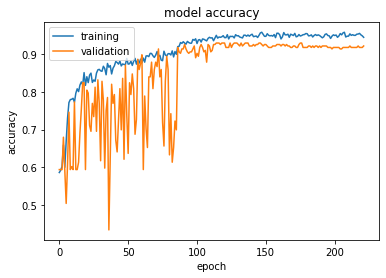

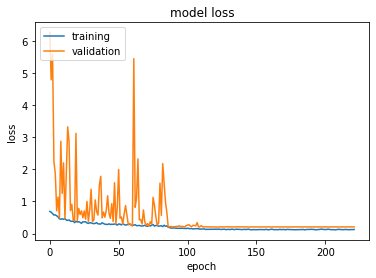

In [ ]:
#plot history
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Chip level predictions

In [ ]:
prediction = il_model.predict(x_test, verbose=0)>thresholds[ix]

#get data frame of obs
df=pd.DataFrame(prediction)
df
#write out
df.to_csv('UNet3_imgpredictions.csv')

Pixel level predictions

In [ ]:
pl_pred = pl_model.predict(x_test)
pl_pred.shape

(512, 256, 256, 1)

In [ ]:
pl_pred[0,...,0]

In [ ]:
np.save('drive/MyDrive/DeepLearning/ModelHistory/UNet_3/UNet3_predictions.npy',pl_pred[...,0])

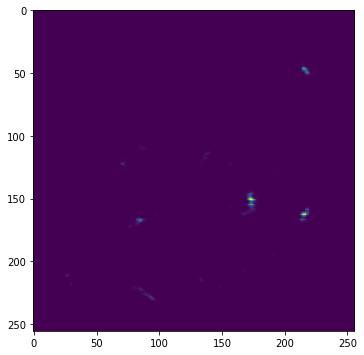

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(pl_pred[36,...,0])

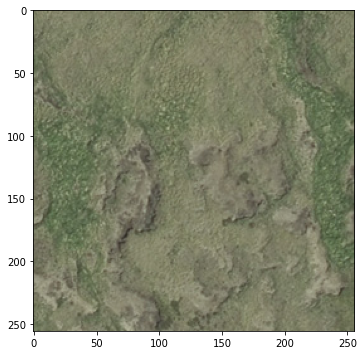

In [ ]:
plt.imshow(x_test[36,...,0:3])
plt.rcParams["figure.figsize"] = (25/2.54,15/2.54)
plt.show()

In [ ]:
x_test.shape

(512, 256, 256, 4)


**Load and predict over unseen data with models**

load chip level model

In [ ]:
#load the model
model2 = keras.models.load_model('UNet_3_il_model.h5')
model2.compile(optimizer=keras.optimizers.Adam(lr=0.1),
                      loss="binary_crossentropy",
                      metrics=['binary_accuracy'])

model2.summary()

In [ ]:
#load test dataset 2
test2array = np.load('test2array.npy')
# test data
test2Data = test2array[...,0:4]
test2Data.shape

# test label
test2Label = test2array[...,4].max(axis=(1,2))
test2Label.shape

x_test2 = test2Data
y_test2 = test2Label
x_test2 = x_test2.astype("float32") / 255
print(x_test2.shape[0], "test samples")

511 test samples


In [ ]:
#evaluate model performance with the new data
score = model2.evaluate(x_test2, y_test2, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6347871422767639
Test accuracy: 0.7925636172294617


load pixel level model

In [ ]:
model3 = keras.models.load_model('UNet_3_pl_model.h5')


In [ ]:
load_status = model3.load_weights('UNet_3_pl_model_weights')
load_status.assert_consumed()


make predictions at the pixel level

In [ ]:
pl_pred = model3.predict(x_test2)
pl_pred.shape


(511, 256, 256, 1)

write out predictions

In [ ]:
np.save('UNet3_test2_predictions.npy',pl_pred[...,0])

Testing on Yorkshire

In [ ]:
yorkshirearray = np.load('yorkshireArray.npy')
# test data
yorkshireData = yorkshirearray[...,0:4]
yorkshireData.shape

# test label
yorkshireLabel = yorkshirearray[...,4].max(axis=(1,2))
yorkshireLabel.shape

x_test = yorkshireData
y_test = yorkshireLabel
x_test = x_test.astype("float32") / 255
print(x_test.shape[0], "test samples")

1024 test samples


Chip level

In [ ]:
#chip level evaluation
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8833791017532349
Test accuracy: 0.830078125


In [ ]:
from sklearn.metrics import precision_recall_curve
prediction = model2.predict(x_test, verbose=0)

#find f measure - optimal theshold for best balance across precision and recall (harmonic mean)
# convert to f score
precision, recall, thresholds = precision_recall_curve(y_test,  prediction[...,0])
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.011270, F-Score=0.648


In [ ]:
#chip level predictions
img_pred = model2.predict(x_test)
img_pred.shape

(1024, 1)

In [ ]:
#save chip level
prediction = model2.predict(x_test, verbose=0)>thresholds[ix]

#get data frame of obs
df=pd.DataFrame(prediction)
df
#write out
df.to_csv('Yorkshire_imgpredictions.csv')

Pixel level predictions

In [ ]:
# pixel level 
pl_pred = model3.predict(x_test)
pl_pred.shape

(1024, 256, 256, 1)

In [ ]:
np.save('Yorkshire_pxlpredictions.npy',pl_pred[...,0])